# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import time
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.amax(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


## 4. Training using DDPG

**Credit:** I have the DDPG code from DDPG_Pendulum folder, and made some appropriate changes to tweak the hyperparemeters

### 4.1. Important notes from Project instructions
After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores. This yields a single score for each episode.

### 4.2. First attempt

Discounting is turned on and set to 0.99 

#### 4.2.1 Hyperparameters

- num_agents=2
- state_size=24 (and taken from the environment)
- action_size=2 (and taken from the environment)
- random_seed=1
- gamma=0.99
- tau=8e-2
- lr_actor=2e-4
- lr_critic=2e-3
- weight_decay=0.
- mu=0.
- theta=0.12
- sigma=0.2 
- learn_rate=10
- time_update=10
- batch_size=256
- buffer_size=int(1e5)

In [6]:
from ddpg_agent_updated_v2 import Agent
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
    
# After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
# This yields a single score for each episode.

# The above note in the project instructions notes that we are not discounting the rewards. However for my first attempt I am discounting the rewards (though very close to 1)
agents = Agent(num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=1, gamma=0.99, tau=8e-2, lr_actor=2e-4, lr_critic=2e-3, weight_decay=0., mu=0., theta=0.12, sigma=0.2, learn_rate=10, time_update=10, batch_size=256, buffer_size=int(1e5))

### 4.3. Actual Training with the above hyperparameters

In [8]:
# This cell was executed and the results of the cell are below. However for reasons unknown to me the cell is not showing a number or *.
            
def ddpg(print_every=100, name=''):
    ''' DDPG Algorithm
        
        Params
            n_episode (int): maximum number of training episodes
            max_t (int): maximum number of timesteps per episode
            print_every (int) : frequency of printing information throughout iteration 
    '''
    
    individual_max_scores = []                                      # Max scores from each episode
    mean_scores = []
    scores_window = deque(maxlen=print_every)
    times_window = deque(maxlen=print_every)
    
    i_episode = 0
        
    while True:
        
        i_episode += 1
        
        env_info = env.reset(train_mode=True)[brain_name]     # Reset the environment    
        states = env_info.vector_observations                 # Get the current states (for each agent)        
        
        agents.reset()
        
        scores = np.zeros(num_agents)                       # Reset the score
        start_time = time.time()                              # Record start time
        
        t = 0
        while t <= 2000:
            actions = agents.act(states) # Action for the state
            env_info = env.step(actions)[brain_name]     # Get the new details of the environment
            
            next_states = env_info.vector_observations      # Get the next state
            rewards = env_info.rewards                   # Get the reward
            dones = env_info.local_done                    # Get the done value
            
            agents.step(t, states, actions, rewards, next_states, dones)
                
            states = next_states
            scores += rewards
            
            t += 1
            
            # Check if the episode is done
            if np.any(dones):
                break 
        
        # Note from project instructions: 
        # After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. 
        # This yields 2 (potentially different) scores. 
        # We then take the maximum of these 2 scores.
        # This yields a single score for each episode.
        
        # Here, scores is a vector of all the scores after adding up the rewards for each agent w/o discounting
        # We will take the max of the these scores and add to 
        # calculate the mean score of all the agents for this episode and add to the mean
        last_max = np.max(scores)
        individual_max_scores.append(last_max) 
        
        # Note from project instructions: 
        # The environment is considered solved, when the average (over 100 episodes) of those scores is at least +0.5.
        # add the max score of all the agents for this episode to the sliding window
        scores_window.append(last_max)
        
        # add the time for this episode to the sliding window
        times_window.append(time.time()-start_time)
        
        # The mean of the scores window
        last_mean = np.mean(scores_window)
        
        mean_scores.append(last_mean)
        
        # The mean of the times window
        mean_time = np.mean(times_window)
        
        print('\rEpisode {}\tEpisode Mean: {:.2f}\tSliding Max: {:.2f}\tNon-zero Count: {:d}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores), np.max(scores_window), np.count_nonzero(scores_window),last_mean), end="")
        agents.save(name)
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tEpisode Mean: {:.2f}\tSliding Max: {:.2f}\tNon-zero Count: {:d}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores), np.max(scores_window), np.count_nonzero(scores_window),last_mean))
        
        if last_mean > 0.5 and i_episode > 100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, last_mean))
            agents.save()
            break
            
    return individual_max_scores, mean_scores

### 4.4. Plotting of the results

Episode 100	Episode Mean: -0.00	Sliding Max: 0.19	Non-zero Count: 13	Average Score: 0.0135
Episode 200	Episode Mean: -0.00	Sliding Max: 0.20	Non-zero Count: 40	Average Score: 0.0429
Episode 300	Episode Mean: 0.05	Sliding Max: 0.20	Non-zero Count: 48	Average Score: 0.05044
Episode 400	Episode Mean: 0.30	Sliding Max: 0.30	Non-zero Count: 61	Average Score: 0.06911
Episode 500	Episode Mean: 0.15	Sliding Max: 0.30	Non-zero Count: 63	Average Score: 0.07222
Episode 600	Episode Mean: 0.05	Sliding Max: 0.30	Non-zero Count: 62	Average Score: 0.07288
Episode 700	Episode Mean: 0.05	Sliding Max: 0.50	Non-zero Count: 76	Average Score: 0.10803
Episode 800	Episode Mean: 0.15	Sliding Max: 0.60	Non-zero Count: 88	Average Score: 0.14354
Episode 900	Episode Mean: 0.40	Sliding Max: 1.40	Non-zero Count: 91	Average Score: 0.21066
Episode 1000	Episode Mean: 0.15	Sliding Max: 2.60	Non-zero Count: 91	Average Score: 0.3833
Episode 1047	Episode Mean: 2.55	Sliding Max: 2.60	Non-zero Count: 94	Average Score: 0.5184

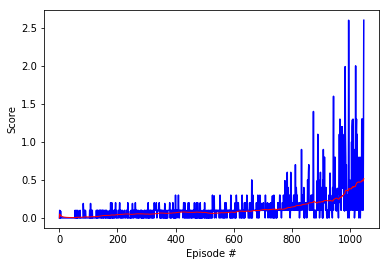

In [7]:
scores, mean_scores = ddpg(print_every=100)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores,'b',label='Episode Scores')
plt.plot(np.arange(1, len(scores)+1), mean_scores,'r',\
         linewidth=1,label='Avg. score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4.5. First attempt

Discounting is turned off (set the gamma to 1) 

#### 4.5.1 Hyperparameters

- num_agents=2
- state_size=24 (and taken from the environment)
- action_size=2 (and taken from the environment)
- random_seed=1
- gamma=1.
- tau=8e-2
- lr_actor=2e-4
- lr_critic=2e-3
- weight_decay=0.
- mu=0.
- theta=0.12
- sigma=0.2 
- learn_rate=10
- time_update=10
- batch_size=256
- buffer_size=int(1e5)

### 4.6. Actual Training with the above hyperparameters followed by plotting of the results

In [ ]:
# Keeping the batch size as 256 and moving to gamma of 1 i.e., no discounting
agents = Agent(num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=1, gamma=1., tau=8e-2, lr_actor=2e-4, lr_critic=2e-3, weight_decay=0., mu=0., theta=0.12, sigma=0.2, learn_rate=10, time_update=10, batch_size=256, buffer_size=int(1e5))

scores, mean_scores = ddpg(print_every=100)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores,'b',label='Episode Scores')
plt.plot(np.arange(1, len(scores)+1), mean_scores,'r',\
         linewidth=1,label='Avg. score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Episode Mean: -0.00	Sliding Max: 0.10	Non-zero Count: 2	Average Score: 0.0020
Episode 200	Episode Mean: 0.10	Sliding Max: 0.10	Non-zero Count: 19	Average Score: 0.01822
Episode 300	Episode Mean: -0.00	Sliding Max: 0.49	Non-zero Count: 50	Average Score: 0.0664
Episode 400	Episode Mean: -0.00	Sliding Max: 0.60	Non-zero Count: 70	Average Score: 0.1208
Episode 500	Episode Mean: 0.20	Sliding Max: 0.69	Non-zero Count: 86	Average Score: 0.17867
Episode 600	Episode Mean: 0.05	Sliding Max: 0.90	Non-zero Count: 91	Average Score: 0.18599
Episode 700	Episode Mean: 0.15	Sliding Max: 0.50	Non-zero Count: 91	Average Score: 0.15900
Episode 800	Episode Mean: -0.00	Sliding Max: 0.59	Non-zero Count: 93	Average Score: 0.1741
Episode 801	Episode Mean: 0.15	Sliding Max: 0.59	Non-zero Count: 93	Average Score: 0.1751

When finished, you can close the environment.

In [8]:
env.close()